# Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from skimage.io import imread, imshow
from skimage import transform, img_as_float
import glob
import math
from importlib import reload

## Import utility functions and load data

In [2]:
cwd = os.getcwd()
path = os.path.join(cwd, '..', 'src')
if not path in sys.path:
    sys.path.append(path)
#del cwd, path
import KaggleAmazonMain as kam

In [30]:
reload(kam)

<module 'KaggleAmazonMain' from 'C:\\Users\\ablin\\Documents\\Kaggle\\kaggle_UnderstandingAmazonFromSpace\\develop\\..\\src\\KaggleAmazonMain.py'>

In [23]:
#Load from pickle unless something has changed
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')
X_sample, labels, names_train, tagged_df = kam.load_sample_training_data() #load sample data for plotting

cwd C:\Users\ablin\Documents\Kaggle\kaggle_UnderstandingAmazonFromSpace\develop
Loading jpg image dataset


In [24]:
X.head()

,b_bimodal,b_kurtosis,b_max,b_mean,b_min,b_skew,b_std,canny_colmean_std,canny_kurtosis,canny_max,...,r_skew,r_std,sobel_colmean_std,sobel_kurtosis,sobel_max,sobel_mean,sobel_min,sobel_rowmean_std,sobel_skew,sobel_std
0,0.01,0.584727,0.462745,0.406310,0.356863,0.143465,0.010151,0.000000,-3.000000,False,...,0.349179,0.016714,0.005138,1.217262,0.041441,0.008595,0.0,0.001003,0.924947,0.005138
1,0.06,2.618875,0.513725,0.252163,0.149020,1.108335,0.037304,0.272732,7.444017,True,...,1.192432,0.070699,0.013688,11.418476,0.155384,0.016621,0.0,0.003938,2.547510,0.013688
2,0.05,-0.771360,0.388235,0.198906,0.105882,0.312114,0.031379,0.209695,16.741803,True,...,0.378112,0.073480,0.009609,7.456124,0.136638,0.012053,0.0,0.002302,1.986216,0.009609
3,0.02,14.326384,0.874510,0.427071,0.313725,3.669470,0.047856,0.118088,65.711219,True,...,3.555662,0.090548,0.012798,53.560918,0.271884,0.006004,0.0,0.003478,6.146419,0.012798
4,0.29,-0.224812,0.952941,0.494552,0.298039,1.066036,0.175244,0.323397,3.561546,True,...,0.918842,0.212183,0.014765,2.781539,0.124231,0.019790,0.0,0.003197,1.409351,0.014765


In [25]:
y.head()

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
train_0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
train_1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
train_10,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1
train_100,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
train_1000,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0


In [26]:
print(X.shape, y.shape)

(40479, 44) (40479, 17)


## Exploratory plots

There are 17 unique tags in this data


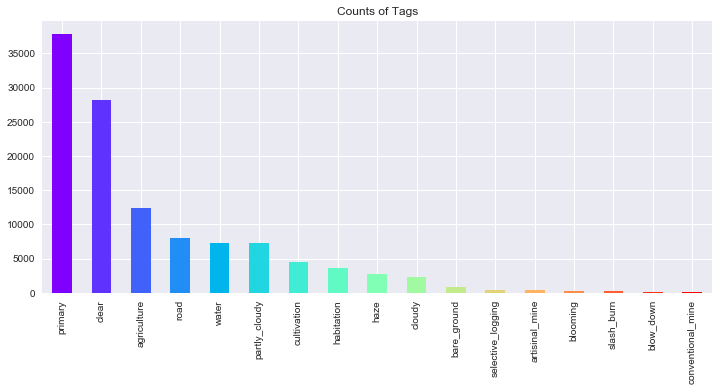

In [6]:
#Barplot of tag counts
%matplotlib inline
def plot_sample_size(tagged_df):
    plt.rcParams['figure.figsize'] = (12, 5)
    print('There are {} unique tags in this data'.format(len(tagged_df.columns)))
    colors = cm.rainbow(np.linspace(0, 1, len(tagged_df.columns)))
    tagged_df.sum().sort_values(ascending=False).plot(title="Counts of Tags", color=colors, kind='bar')
    plt.show()
plot_sample_size(tagged_df)

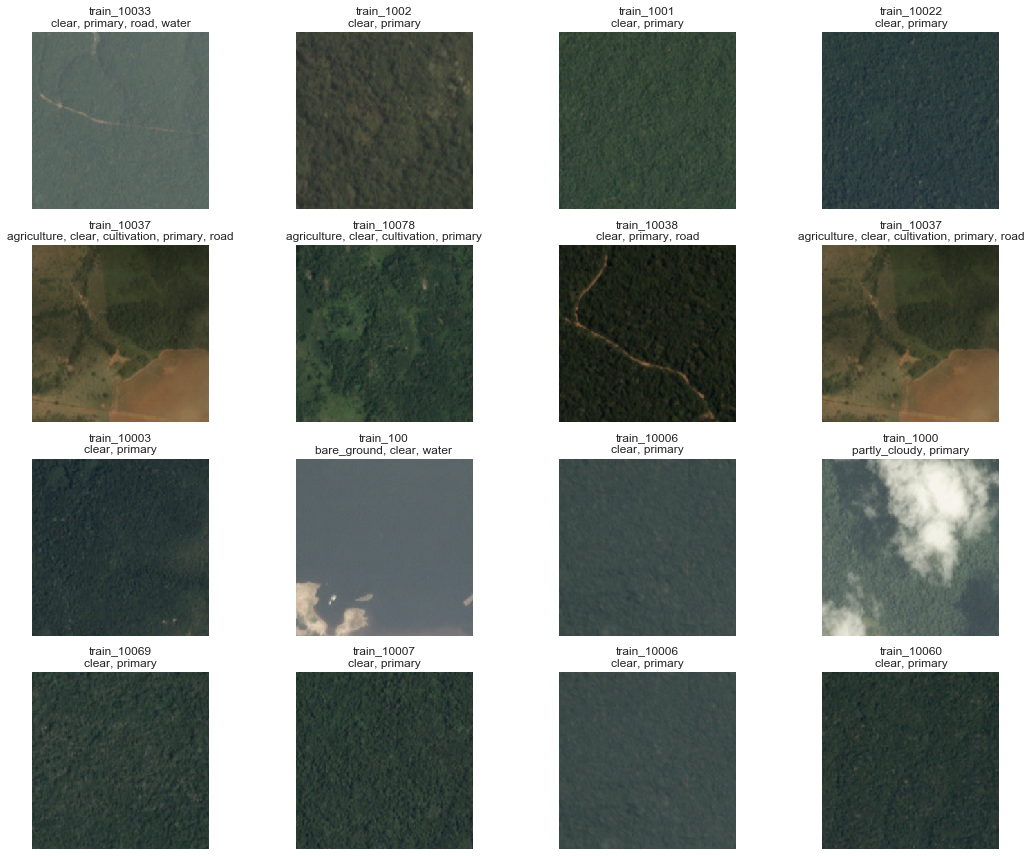

In [7]:
kam.plot_samples(X_sample, names_train, tagged_df, nrow=4, ncol=4)

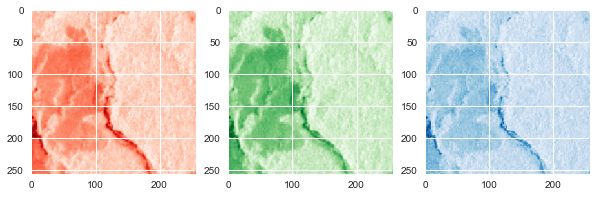

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(10, 6))
axes[0].imshow(X_sample[1,:,:,0], cmap='Reds')
axes[1].imshow(X_sample[1,:,:,1], cmap='Greens')
axes[2].imshow(X_sample[1,:,:,2], cmap='Blues')

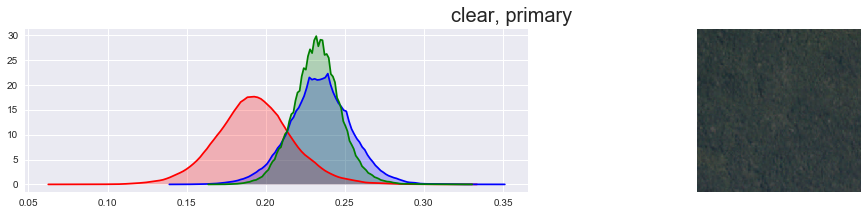

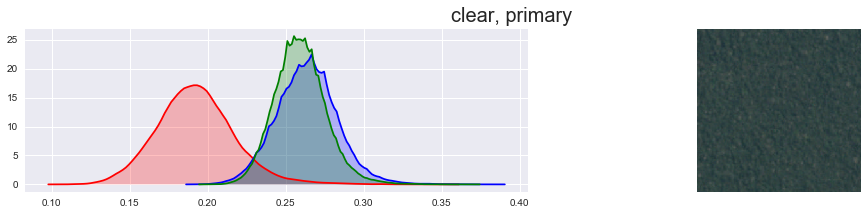

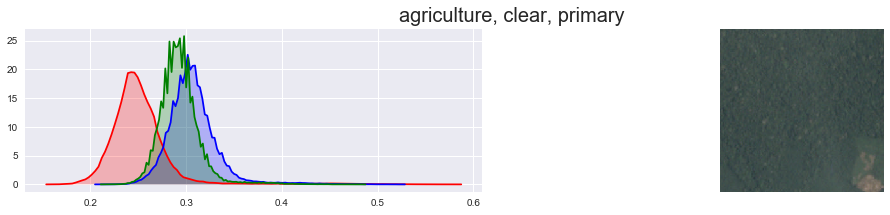

In [9]:
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(0,3):
    sample = np.random.randint(low=0, high=X_sample.shape[0]-1, size = 1)
    ind = names_train[sample[0]]
    tags = kam.get_labels(ind, tagged_df)
    kam.plot_rgb_dist(X_sample[sample[0],:,:,:],tags)

Create features from the raw pixel data. These metrics should be metrics that describe patterns in the trends and distributions of the pixels. 
Using binned historgram features to capture bimodality and general shape and location of distributions in red, green, and blue.

I want to try an ML algorithm with feature cdreation, and a NN with raw pixel data to compare results. 

binned mode differences is a feature created to discribe bimodal distributions. A lot of the r g b distributions are bimodal, which could offer interesting insight into the  classificatioin, so I created a feature to capture bimodal patterns in the r g b pixel distributions. The binned mode differences is simply the differnce between the two min bounds of the two largest count bins, or the two modes. If this value is large, then the two larges modes are a large distance from eachother, indicating the distribution is bimodal.

The mean of the red distribution is 0.22
After splitting on the mean, the two modes are found at [ 0.16] and [ 0.3]


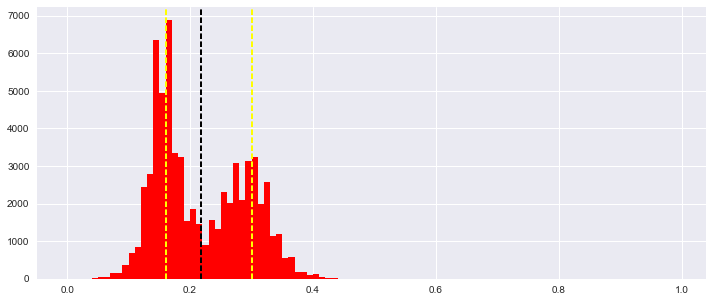

The mean of the green distribution is 0.22
After splitting on the mean, the two modes are found at [ 0.2] and [ 0.27]


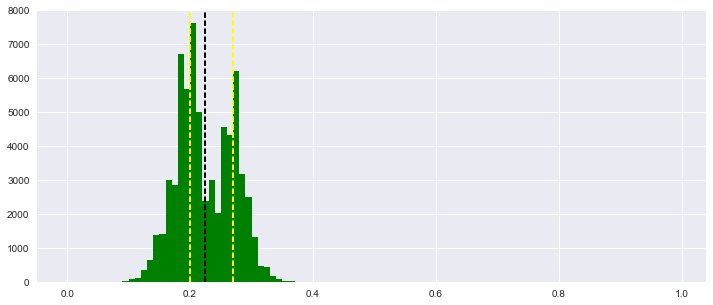

The mean of the blue distribution is 0.2
After splitting on the mean, the two modes are found at [ 0.18] and [ 0.23]


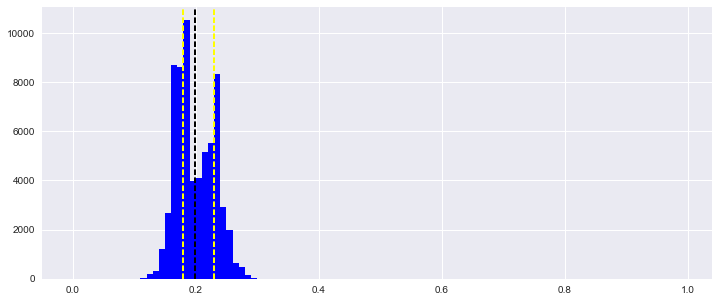

(0.14000000000000001, 0.070000000000000007, 0.050000000000000003)

In [11]:
#Binned mode differences
img=X_sample[2]
steps=np.arange(start=0,stop=1, step=.01)
kam.binned_mode_features_with_diagnostics(img, steps)

Also created sobel features. blah blah blah about those

In [10]:
from skimage.color import rgb2gray
from skimage import transform, img_as_float, filters
X_train_g = rgb2gray(X_sample)

X_train_sobel = []
for i in range(X_train_g.shape[0]):
    X_train_sobel.append(filters.sobel(X_train_g[i]))
X_train_sobel = np.asarray(X_train_sobel)

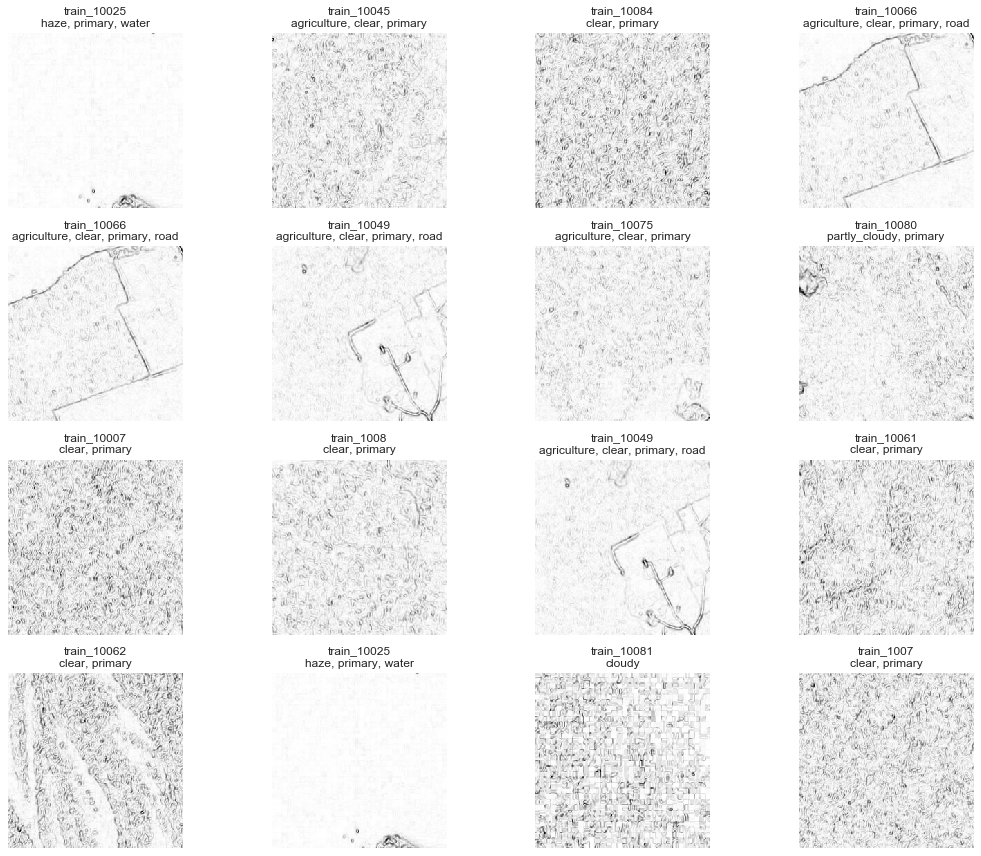

In [11]:
kam.plot_samples(X_train_sobel, names_train, tagged_df, 4,4)

Check out the features that were made... See if they describe separation of  classes. 

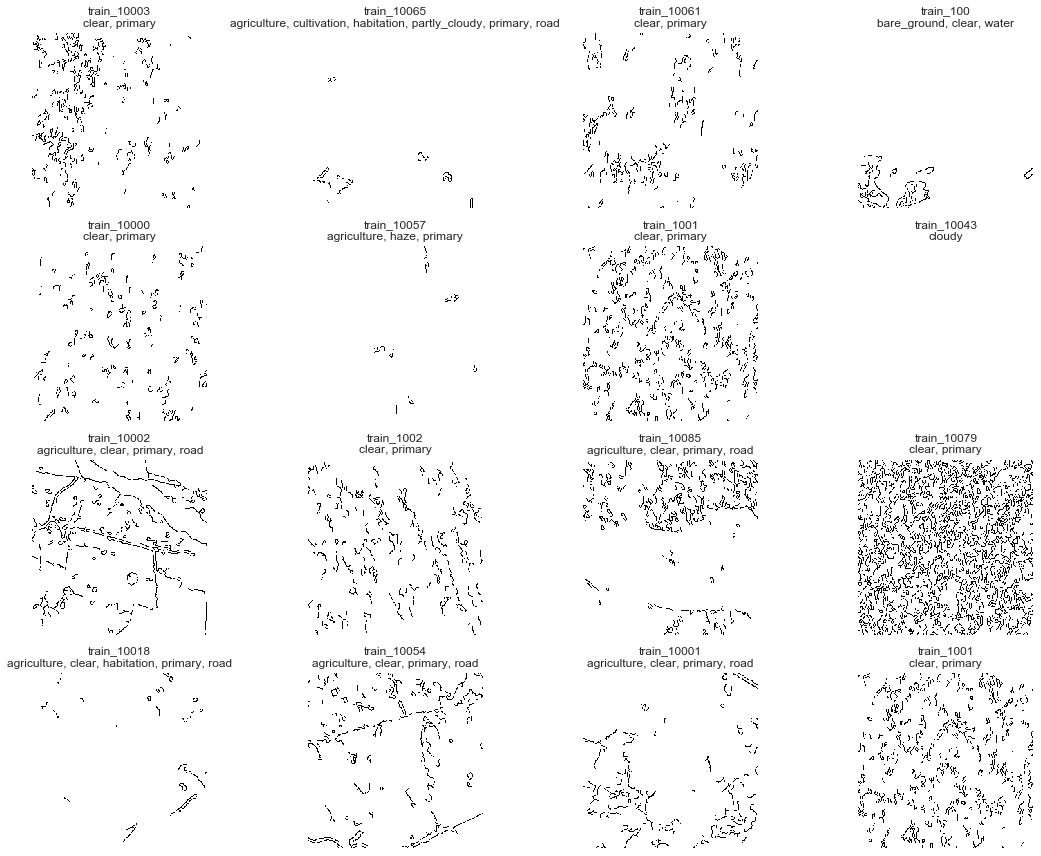

In [16]:
sample_imgs_canny = kam.xform_to_canny(X_sample, sigma=.5)

kam.plot_samples(sample_imgs_canny, names_train, tagged_df, 4,4)

In [22]:
X

,b_bimodal,b_kurtosis,b_max,b_mean,b_min,b_skew,b_std,canny_colmean_std,canny_kurtosis,canny_max,...,r_skew,r_std,sobel_colmean_std,sobel_kurtosis,sobel_max,sobel_mean,sobel_min,sobel_rowmean_std,sobel_skew,sobel_std
train_0,0.01,0.584727,0.462745,0.406310,0.356863,0.143465,0.010151,0.000000,-3.000000,False,...,0.349179,0.016714,0.005138,1.217262,0.041441,0.008595,0.0,0.001003,0.924947,0.005138
train_1,0.06,2.618875,0.513725,0.252163,0.149020,1.108335,0.037304,0.272732,7.444017,True,...,1.192432,0.070699,0.013688,11.418476,0.155384,0.016621,0.0,0.003938,2.547510,0.013688
train_10,0.05,-0.771360,0.388235,0.198906,0.105882,0.312114,0.031379,0.209695,16.741803,True,...,0.378112,0.073480,0.009609,7.456124,0.136638,0.012053,0.0,0.002302,1.986216,0.009609
train_100,0.02,14.326384,0.874510,0.427071,0.313725,3.669470,0.047856,0.118088,65.711219,True,...,3.555662,0.090548,0.012798,53.560918,0.271884,0.006004,0.0,0.003478,6.146419,0.012798
train_1000,0.29,-0.224812,0.952941,0.494552,0.298039,1.066036,0.175244,0.323397,3.561546,True,...,0.918842,0.212183,0.014765,2.781539,0.124231,0.019790,0.0,0.003197,1.409351,0.014765
train_10000,0.02,0.429215,0.278431,0.189714,0.121569,0.058111,0.015533,0.179643,24.987007,True,...,0.184504,0.021148,0.007937,0.795522,0.062312,0.013851,0.0,0.001658,0.779471,0.007937
train_10001,0.03,4.008790,0.447059,0.206802,0.117647,0.564638,0.027009,0.184059,23.517918,True,...,0.957850,0.058280,0.008916,7.738297,0.103869,0.012574,0.0,0.002542,1.827587,0.008916
train_10002,0.04,-0.606894,0.592157,0.437793,0.317647,-0.311665,0.046312,0.236405,11.893166,True,...,-0.561227,0.088608,0.013075,5.937909,0.113043,0.014304,0.0,0.002863,2.145832,0.013075
train_10003,0.01,5.378336,0.458824,0.207245,0.129412,0.593554,0.017497,0.212480,16.149559,True,...,0.914493,0.027240,0.009020,7.946293,0.129729,0.013810,0.0,0.002304,1.672655,0.009020
train_10004,0.02,0.711745,0.227451,0.155210,0.098039,0.126930,0.011896,0.019914,2515.615782,True,...,0.212165,0.016746,0.005047,1.061199,0.038346,0.008369,0.0,0.001033,0.902769,0.005047


In [29]:
y.index

Index(['train_0', 'train_1', 'train_10', 'train_100', 'train_1000',
       'train_10000', 'train_10001', 'train_10002', 'train_10003',
       'train_10004',
       ...
       'train_9990', 'train_9991', 'train_9992', 'train_9993', 'train_9994',
       'train_9995', 'train_9996', 'train_9997', 'train_9998', 'train_9999'],
      dtype='object', length=40479)

Index(['b_bimodal', 'b_kurtosis', 'b_max', 'b_mean', 'b_min', 'b_skew',
       'b_std', 'canny_colmean_std', 'canny_kurtosis', 'canny_max',
       'canny_mean', 'canny_min', 'canny_rowmean_std', 'canny_skew',
       'canny_std', 'g_bimodal', 'g_kurtosis', 'g_max', 'g_mean', 'g_min',
       'g_skew', 'g_std', 'hough_kurtosis', 'hough_max', 'hough_mean',
       'hough_min', 'hough_skew', 'hough_std', 'n_blobs', 'r_bimodal',
       'r_kurtosis', 'r_max', 'r_mean', 'r_min', 'r_skew', 'r_std',
       'sobel_colmean_std', 'sobel_kurtosis', 'sobel_max', 'sobel_mean',
       'sobel_min', 'sobel_rowmean_std', 'sobel_skew', 'sobel_std'],
      dtype='object')


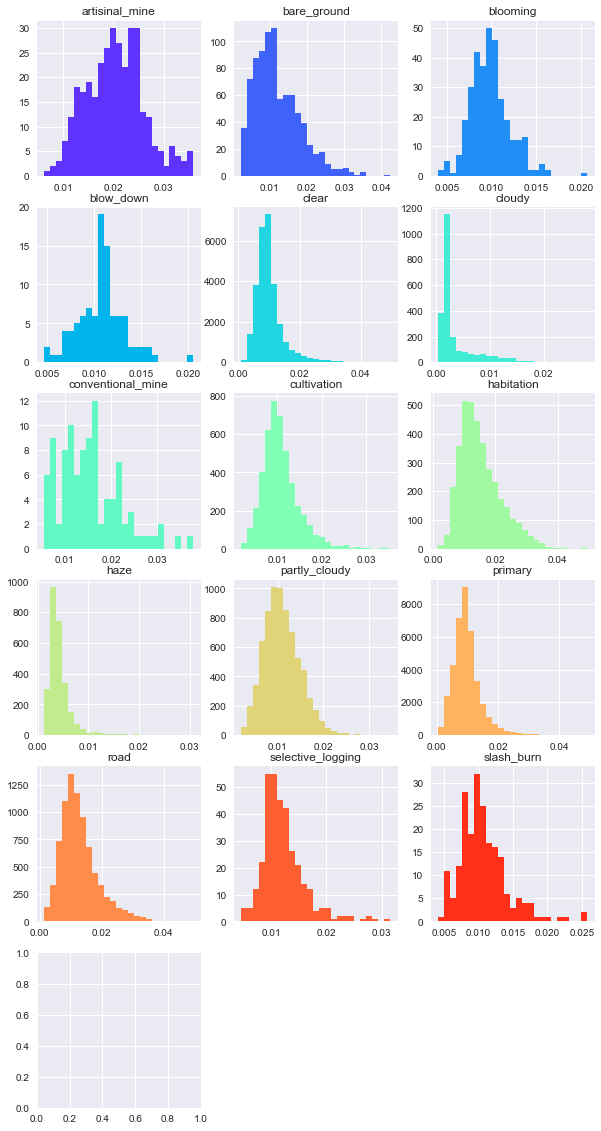

In [32]:
#create table of each feature histograms for each label
X.set_index(y.index, inplace=True)
print(X.columns) #possible features to plot    
        
#plot_a_feature_by_labels('b_bimodal')        
kam.plot_a_feature_by_labels('sobel_colmean_std', X, y)

# Random Forest

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.40, random_state=14113)

In [14]:
y.sum() #these are the sample sizes per class

agriculture          12338
artisinal_mine         339
bare_ground            859
blooming               332
blow_down               98
clear                28203
cloudy                2330
conventional_mine      100
cultivation           4477
habitation            3662
haze                  2695
partly_cloudy         7251
primary              37840
road                  8076
selective_logging      340
slash_burn             209
water                 7262
dtype: int64

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, 
                            max_features = 'sqrt',
                            bootstrap = True, 
                            oob_score = True,
                            n_jobs = -1,
                            random_state = 14113,
                            class_weight = 'balanced_subsample')

In [16]:
rf.fit(X_train, y_train)
print('The oob error for this random forest is {}'.format(rf.oob_score_.round(2)))

The oob error for this random forest is 0.95


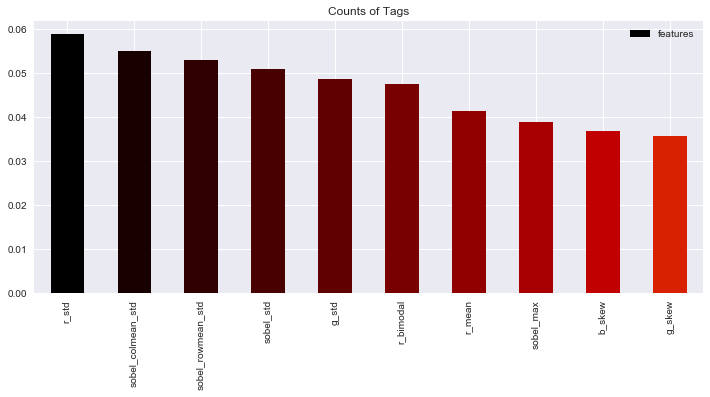

In [17]:
#features ranking of features. 

Feature_importance = pd.DataFrame(rf.feature_importances_, X_train.columns)
def plot_feature_importance(Feature_importance, n):
    '''
    plot top n features
    '''
    plt.rcParams['figure.figsize'] = (12, 5)
    Feature_importance = pd.DataFrame(rf.feature_importances_, X_train.columns)
    Feature_importance.columns = ['features']
    Feature_importance = Feature_importance.sort_values(by='features', axis=0, ascending=False)
    colors = cm.gist_heat(np.linspace(0, 1, len(tagged_df.columns)))
    Feature_importance.head(n).plot(title="Counts of Tags", color=colors, kind='bar')
    plt.show()

plot_feature_importance(Feature_importance, 10)


## F2-score and other metrics

In [18]:
from sklearn.metrics import fbeta_score
np.asarray(y_validation)

predictions = rf.predict(X_validation)
fbeta_score(np.asarray(y_validation), predictions, beta=2, average='samples')

C:\Users\clongo\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


0.8370163549164279

precision is  of the imgaes taggd with a particular class, how many times that was the right class. 
recall is of the images of a certain class, how many we correctly identified as that class. 
f score is a blah average of precision and recall. 
support is the same size of images with that label in the training data. 
blah blah blah add descriptions of these metrics 

In [19]:
#calc some other scoring metrics. precision, recall, and f1.
#The confusion matrix is diddicult to make and read for miltilabel classificatoin, but this table shows the same information 
#it shows the classes the model is perfomring well and poorly on.
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_validation, predictions)
Metrics = pd.DataFrame([precision, recall, support], index=['precision', 'recall', 'support'])
Metrics.columns = y_validation.columns
Metrics

C:\Users\clongo\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
precision,0.794624,0.970588,1.000000,0.0,0.0,0.937878,0.850192,0.0,0.676364,0.805369,0.780987,0.926775,0.970510,0.754006,0.0,0.0,0.795229
recall,0.740926,0.235714,0.005634,0.0,0.0,0.965777,0.761468,0.0,0.103448,0.392927,0.580501,0.748753,0.992084,0.576240,0.0,0.0,0.272387
support,4987.000000,140.000000,355.000000,133.0,46.0,11396.000000,872.000000,44.0,1798.000000,1527.000000,1118.000000,2806.000000,15160.000000,3266.000000,140.0,86.0,2937.000000


Trying to show recall increases with sample size, but its hard to see all the small sample points because they are so clustered. Basically, recall for sample size less than 2000 is generally poor, so we will focus on those samples.

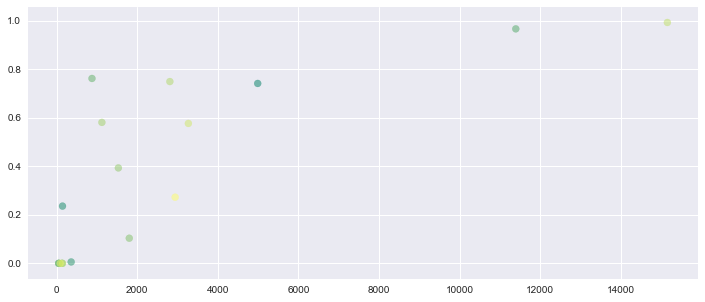

In [20]:
#Plot recall by sample size
# to show sample size thresh where recall is ok

colors=cm.summer(np.linspace(0, 1, len(Metrics.ix['support'])))
plt.scatter(Metrics.ix['support'], Metrics.ix['recall'], c=colors, alpha=0.5)
plt.show()

## Diagnostics

In [21]:
probs = rf.predict_proba(X_validation)

ROC curves visualize performance of a class/binary classifier. Visualization of how predicted probabilities compare to the truth. 

C:\Users\clongo\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


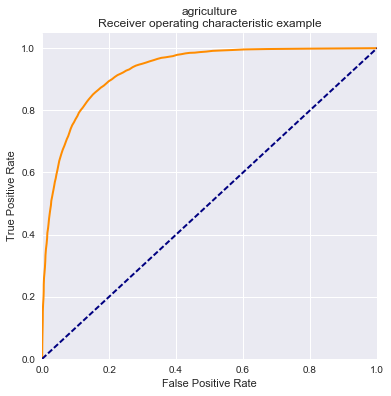

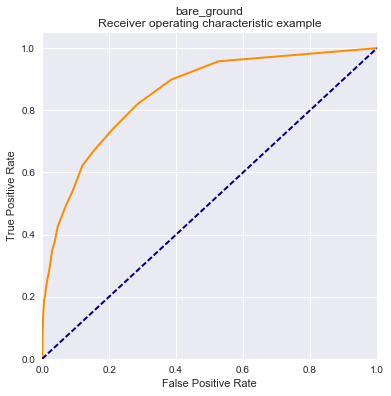

In [22]:
from sklearn import metrics

def plot_ROC(tag):
    '''
    plot ROC curve for a specific tag
    '''
    plt.rcParams['figure.figsize'] = (6,6)
    n = np.where(y_validation.columns==tag)[0][0]
    fpr, tpr, threshs = metrics.roc_curve(y_validation[tag], probs[n][:,1],
                                          pos_label=None, sample_weight=None, drop_intermediate=False)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(tag+'\nReceiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
plot_ROC('agriculture')
plot_ROC('bare_ground')

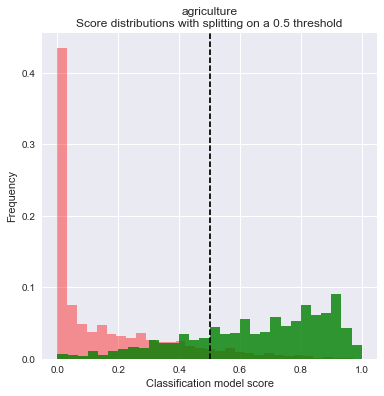

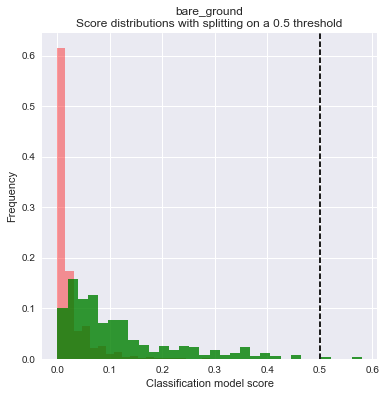

In [23]:
def plot_decision_hist(tag):
    '''
    plots decision histograms with thresholds
    '''
    plt.rcParams['figure.figsize'] = (6,6)
    #Less than .5 is 0. greater is 1
    n = np.where(y_validation.columns==tag)[0][0]
    probs_df = pd.DataFrame(probs[n][:,1]).set_index(y_validation[tag])
    class0 =  np.array(probs_df.ix[0][0]) #0 does not have true tag
    class1 =  np.array(probs_df.ix[1][0]) #1 does have true tag

    S = class0
    # Histogram:
    # Bin it
    n, bin_edges = np.histogram(S, 30)
    # Normalize it, so that every bins value gives the probability of that bin
    bin_probability = n/float(n.sum())
    # Get the mid points of every bin
    bin_middles = (bin_edges[1:]+bin_edges[:-1])/2.
    # Compute the bin-width
    bin_width = bin_edges[1]-bin_edges[0]
    # Plot the histogram as a bar plot
    plt.bar(bin_middles, bin_probability, width=bin_width, color='red', alpha=.4)

    S = class1
    n, bin_edges = np.histogram(S, 30)
    bin_probability = n/float(n.sum())
    bin_middles = (bin_edges[1:]+bin_edges[:-1])/2.
    bin_width = bin_edges[1]-bin_edges[0]
    plt.bar(bin_middles, bin_probability, width=bin_width, color='green', alpha=.8)

    plt.axvline(x=0.5, color='k', linestyle='--')
    plt.title(tag+'\nScore distributions with splitting on a 0.5 threshold')
    plt.xlabel('Classification model score')
    plt.ylabel('Frequency')
    plt.show()
    
plot_decision_hist('agriculture')
plot_decision_hist('bare_ground')    

Notice bare ground shows no separation at all, really. 

# Oversampling

The imbalanced-learn library imblearn has great modules for oversampling. WE are usign oeversampling because undersampling leads to loss of information, and some classes are very small so it would also lead to a very small dataset. Note oversampling can lead to overfitting the samller classes... Didn't work with multiclasses. I wrote my oen function for oversampling. It oversamples classes smaller than l up to size l by repeating a relabeled image the same as the randomly sampled image. 

In [44]:
X.drop(['hough_skew','hough_kurtosis'], axis=1, inplace=True)

In [45]:
#randomly over sample

def over_sample(X, y, l):
    '''
    resamples classes smaller than l to be size l
    '''
    y_upsampled=y.copy()
    X_upsampled=X.copy()
    cols=y.sum()[y.sum()<l].index #classes with less than l samples.
    for c in cols:
        I_y = y[y[c]==1].sample(n=l-y[c].sum(), replace=True)
        x_index = I_y.index #index of image names
        I_y.reset_index(drop=True, inplace=True) #rename y index
        y_upsampled = y_upsampled.append(I_y, )
        
        I_x = X.loc[x_index]
        I_x.reset_index(drop=True, inplace=True) #rename y index
        X_upsampled = X_upsampled.append(I_x, )

    return X_upsampled, y_upsampled

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.40, random_state=14113)
X_upsampled, y_upsampled = over_sample(X=X_train, y=y_train, l=10000)

In [46]:
y_upsampled.sum()

agriculture           47869
artisinal_mine        11588
bare_ground           14228
blooming              10607
blow_down             10217
clear                 96685
cloudy                10080
conventional_mine     10411
cultivation           26461
habitation            24845
haze                  12695
partly_cloudy         24714
primary              131833
road                  42651
selective_logging     10744
slash_burn            10697
water                 35695
dtype: int64

In [47]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 300, 
                            max_features = 'sqrt',
                            bootstrap = True, 
                            oob_score = False,
                            n_jobs = -1,
                            random_state = 14113,
                            class_weight = 'balanced')

rf.fit(X_upsampled, y_upsampled)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=14113, verbose=0,
            warm_start=False)

In [48]:
from sklearn.metrics import fbeta_score

probs = rf.predict_proba(X_validation)
predictions = kam.get_prediction_matrix(probs, 0.25)

score = fbeta_score(np.asarray(y_validation), predictions, beta=2, average='samples')

print('F2 score: ', score)

F2 score:  0.887465424003


In [57]:
from sklearn.ensemble import ExtraTreesClassifier

In [58]:
et = ExtraTreesClassifier(n_estimators = 300,
                          n_jobs = -1,
                          random_state = 14113,
                          class_weight = 'balanced')

et.fit(X_upsampled, y_upsampled)

ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=False, random_state=14113, verbose=0,
           warm_start=False)

In [59]:
probs = et.predict_proba(X_validation)
predictions = kam.get_prediction_matrix(probs, 0.25)

score = fbeta_score(np.asarray(y_validation), predictions, beta=2, average='samples')

print('F2 score: ', score)

F2 score:  0.882248143642


In [60]:
from sklearn.ensemble import AdaBoostClassifier

In [63]:
ab = AdaBoostClassifier(random_state = 14113)

ab.fit(X_upsampled, y_upsampled)

ValueError: bad input shape (144174, 17)

In [27]:
from sklearn.metrics import fbeta_score

predictions = rf.predict(X_validation)
fbeta_score(np.asarray(y_validation), predictions, beta=2, average='samples')

C:\Users\clongo\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


0.84193954699148854

In [49]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_validation, predictions)
Metrics = pd.DataFrame([precision, recall, support], index=['precision', 'recall', 'support'])
Metrics.columns = y_validation.columns
Metrics

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
precision,0.602496,0.630769,0.408333,0.244444,0.500000,0.890451,0.728611,1.000000,0.370422,0.536131,0.559055,0.749407,0.958991,0.545191,0.295455,0.0,0.450302
recall,0.938841,0.585714,0.138028,0.082707,0.043478,0.989294,0.908257,0.022727,0.590656,0.753111,0.825581,0.900570,0.998021,0.864360,0.092857,0.0,0.735785
support,4987.000000,140.000000,355.000000,133.000000,46.000000,11396.000000,872.000000,44.000000,1798.000000,1527.000000,1118.000000,2806.000000,15160.000000,3266.000000,140.000000,86.0,2937.000000


# LR model for smaller classes
I want to try some logistic regression models for the classes that are performing poorly. These are all the classes with smaller sampling sizes. These classes will be removed from the RF. Try RF witout them and see if it changes performance. Also try binary RF classifyer on the smallers. See if LR is better. 

Start with bare_ground example, since we have seen its poor performance in the RF. 

In [29]:
#Perform LR on these classes. 
l=2000
cols=y.sum()[y.sum()<l].index
cols

Index(['artisinal_mine', 'bare_ground', 'blooming', 'blow_down',
       'conventional_mine', 'selective_logging', 'slash_burn'],
      dtype='object')

Adding a 10-fold cv cause it is needed for LR model. So bootstrapping like the RF

In [ ]:
#Lin reg model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr = LogisticRegression(random_state=1, class_weight='balanced')
# 10-Fold Cross Validation
scores = cross_val_score(lr, X_upsampled, y_upsampled['bare_ground'], cv=10)

np.set_printoptions(precision=8)
print("cross validation scores {}".format(scores)) #the cross_val_score uses the default scoring method from the RF, which is oob error. 
print("Average cross validation accuracy scores: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [31]:
#Metrics and distrubtion plot
lr.fit(X_upsampled, y_upsampled['bare_ground'])
pred_lr = lr.predict(X_validation)
coef_lr = lr.coef_.ravel()
print("Training accuracy is: {}".format(lr.score(X_upsampled, y_upsampled['bare_ground'])))
print('{} percent of the feature have been removed by setting the coefficents to 0'.format((np.mean(coef_lr == 0)*100).round(2)))

Training accuracy is: 0.7239654861486815
3.45 percent of the feature have been removed by setting the coefficents to 0


In [147]:
from sklearn.metrics import fbeta_score
print("The new f2 score for this class is: {}".format(fbeta_score(np.asarray(y_validation['bare_ground']), pred_lr, beta=2))) #This is the score now... 
n = np.where(y_validation.columns== 'bare_ground')[0][0]
print("The f2 score from the multiclass RF is: {}".format(fbeta_score(np.asarray(y_validation['bare_ground']), predictions[:,n], beta=2))) #but this is what it was before

The new f2 score for this class is: 0.2683087750164944
The f2 score from the multiclass RF is: 0.010496850944716583


In [57]:
# try a RF
#RF for larger classes
rf = RandomForestClassifier(n_estimators = 100, 
                            max_features = 'sqrt',
                            bootstrap = True, 
                            oob_score = True,
                            n_jobs = -1,
                            random_state = 14113,
                            class_weight = 'balanced_subsample')

rf.fit(X_upsampled, y_upsampled['bare_ground'])
print('The oob error for this random forest is {}'.format(rf.oob_score_.round(5)))


preds_rf = rf.predict(X_validation)
print("this F2 score is : {}".format(fbeta_score(np.asarray(y_validation['bare_ground']), preds_rf, beta=2)))

The oob error for this random forest is 0.99997
this F2 score is : 0.03467406380027739


In [ ]:
print("The new f2 score for this class is: {}".format(fbeta_score(np.asarray(y_validation['bare_ground']), preds_rf, beta=2))) #This is the score now... 
n = np.where(y_validation.columns== 'bare_ground')[0][0]
print("The f2 score from the multiclass RF is: {}".format(fbeta_score(np.asarray(y_validation['bare_ground']), predictions[:,n], beta=2))) #but this is what it was before

In [116]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_validation['bare_ground'], pred_lr)
Metrics = pd.DataFrame([precision, recall, support], index=['precision', 'recall', 'support'])
Metrics #wow precision is horrible

,0,1
precision,0.992323,0.066109
recall,0.767191,0.735211
support,15837.000000,355.000000


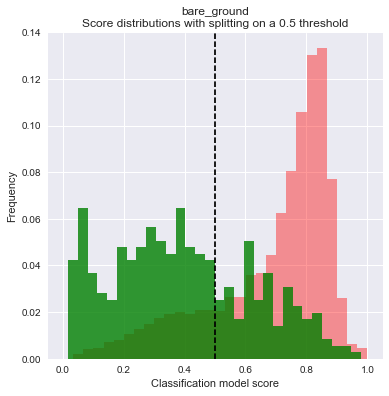

In [148]:

def micro_model_dist_plot(tag, probs):
    '''
    plots decision histograms with thresholds
    '''
    plt.rcParams['figure.figsize'] = (6,6)
    #Less than .5 is 0. greater is 1
    n = np.where(y_validation.columns==tag)[0][0]
    probs_df = pd.DataFrame(probs).set_index(y_validation[tag])
    class0 =  np.array(probs_df.ix[0][0]) #0 does not have true tag
    class1 =  np.array(probs_df.ix[1][0]) #1 does have true tag

    S = class0
    # Histogram:
    # Bin it
    n, bin_edges = np.histogram(S, 30)
    # Normalize it, so that every bins value gives the probability of that bin
    bin_probability = n/float(n.sum())
    # Get the mid points of every bin
    bin_middles = (bin_edges[1:]+bin_edges[:-1])/2.
    # Compute the bin-width
    bin_width = bin_edges[1]-bin_edges[0]
    # Plot the histogram as a bar plot
    plt.bar(bin_middles, bin_probability, width=bin_width, color='red', alpha=.4)

    S = class1
    n, bin_edges = np.histogram(S, 30)
    bin_probability = n/float(n.sum())
    bin_middles = (bin_edges[1:]+bin_edges[:-1])/2.
    bin_width = bin_edges[1]-bin_edges[0]
    plt.bar(bin_middles, bin_probability, width=bin_width, color='green', alpha=.8)

    plt.axvline(x=0.5, color='k', linestyle='--')
    plt.title(tag+'\nScore distributions with splitting on a 0.5 threshold')
    plt.xlabel('Classification model score')
    plt.ylabel('Frequency')
    plt.show()
    
probs = lr.predict_proba(X_validation)
tag='bare_ground'
micro_model_dist_plot(tag, probs)

# Put it all together

In [ ]:
#pick threshold. 
#function to find optimal threshold for recall
#Adam might have this written already
#Just use .5 threshold for now. 

In [ ]:
#Ensemble all models together

#Big model

#Mini Models

In [50]:
#The smaller classes will use a LR model
l=2000
cols_small=y.sum()[y.sum()<l].index
cols_large=y.sum()[y.sum()>=l].index

In [51]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.40, random_state=14113)
X_upsampled, y_upsampled = over_sample(X=X_train, y=y_train, l=10000)

#Same x is used. Need different ys
y_train_mini = y_upsampled[cols_small]
y_train_large = y_upsampled[cols_large]
y_validation_mini = y_validation[cols_small]
y_validation_large = y_validation[cols_large]

In [52]:
#RF for larger classes
rf = RandomForestClassifier(n_estimators = 100, 
                            max_features = 'sqrt',
                            bootstrap = True, 
                            oob_score = True,
                            n_jobs = -1,
                            random_state = 14113,
                            class_weight = 'balanced_subsample')

rf.fit(X_upsampled, y_train_large)
print('The oob error for this random forest is {}'.format(rf.oob_score_.round(5)))


predictions = rf.predict(X_validation)
print("this F2 score is : {}".format(fbeta_score(np.asarray(y_validation_large), predictions, beta=2, average='samples')))

The oob error for this random forest is 0.99839
this F2 score is : 0.8520014973386119


C:\Users\ablin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [53]:
# LR for all smaller classes
from sklearn.linear_model import LogisticRegression
def mini_models(cols_small):
    df = pd.DataFrame()
    for c in cols_small:
        lr = LogisticRegression(random_state=1, class_weight='balanced')
        lr.fit(X_upsampled, y_train_mini[c])
        pred_lr = lr.predict(X_validation)
        df[c] = pred_lr
    return df
preds_mini = mini_models(cols_small)

In [54]:
#put RF scores and LR scores together
preds_large = pd.DataFrame(predictions)
preds_large.columns=cols_large
preds_all = pd.concat([preds_large, preds_mini], axis=1, join_axes=[preds_large.index])
y_validation_all = pd.concat([y_validation[cols_large], y_validation[cols_small]], axis=1, join_axes=[y_validation.index])


precision, recall, fscore, support = score(y_validation_all, preds_all)
Metrics = pd.DataFrame([precision, recall, support], index=['precision', 'recall', 'support'])
Metrics.columns = y_validation_all.columns
Metrics

,agriculture,clear,cloudy,cultivation,habitation,haze,partly_cloudy,primary,road,water,artisinal_mine,bare_ground,blooming,blow_down,conventional_mine,selective_logging,slash_burn
precision,0.779899,0.944223,0.842875,0.625532,0.773499,0.755284,0.921814,0.971427,0.743759,0.764393,0.076467,0.073468,0.018597,0.005673,0.024281,0.03211,0.017167
recall,0.745338,0.958143,0.793578,0.163515,0.447282,0.607335,0.760513,0.991227,0.620331,0.293837,0.921429,0.695775,0.894737,0.782609,0.863636,0.80000,0.744186
support,4987.000000,11396.000000,872.000000,1798.000000,1527.000000,1118.000000,2806.000000,15160.000000,3266.000000,2937.000000,140.000000,355.000000,133.000000,46.000000,44.000000,140.00000,86.000000


In [56]:
#calc F2 score from that. 
print("this F2 score for this weird ensemble method is : {}".format(
    fbeta_score(np.asarray(y_validation_all), preds_all, beta=2, average='samples')))

this F2 score for this weird ensemble method is : 0.7573225088708905


C:\Users\ablin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
